In [1]:
# Processing carbon cycle predictors and training fluxes
# Predictors are mostly at 1x1 degree spatial resolution
# and monthly temporal resolution over North America

In [1]:
import numpy as np
import os.path
from netCDF4 import Dataset
from sklearn import preprocessing
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from cartopy import config
import cartopy.crs as ccrs


# Directory for data
data_dir = "/Users/yshiga/Documents/Research/Carbon_Machine/Monthly/"

In [2]:
# Load in training fluxes, reshape, and transform scale

# filename for inverse carbon fluxes (units are umol/m2/s)
filename_flux = data_dir + "flux_training/geoinv-sif-monthly-2007-to-2015.nc"
nc_inv = Dataset(filename_flux, 'r')  # open inversion file using netcdf reader
nc_inv  # take a look at data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): x(2613), time(108)
    variables(dimensions): int64 x(x), int64 time(time), float64 monthly_flux(time, x), float64 se_monthly_flux(time, x)
    groups: 

In [3]:
# Load in training fluxes, reshape, and transform scale

# filename for modis data
filename_modis = data_dir + "predictors/processed/modis-2007-to-2016-NA-monthly.nc"
nc_modis = Dataset(filename_modis, 'r')  # open inversion file using netcdf reader
nc_modis  # take a look at data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): x(2613), time(120)
    variables(dimensions): float64 lon(x), float64 lat(x), int64 time(time), float64 EVI(x, time), float64 LAI(x, time), float64 NDVI(x, time), float64 NIRv(x, time), float64 SWIR(x, time), float64 fAPAR(x, time)
    groups: 

In [4]:
# filename for sif data
filename_sif = data_dir + "predictors/processed/sif-2007-to-2016-NA-monthly.nc"
nc_sif = Dataset(filename_sif, 'r')  # open inversion file using netcdf reader
nc_sif  # take a look at data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): time(120), x(2613)
    variables(dimensions): int64 time(time), float64 lon(x), float64 lat(x), float64 GOME2A::SIF(x, time), float64 GOME2B::SIF(x, time), float64 GOSAT::SIF(x, time), float64 OCO2::SIF(x, time), float64 RSIF::SIF(x, time)
    groups: 

In [5]:
# filename for narr data
filename_narr = data_dir + "predictors/processed/narr-2011-NA-monthly.nc"
nc_narr = Dataset(filename_narr, 'r')  # open inversion file using netcdf reader
nc_narr  # take a look at data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): time(12), x(2613)
    variables(dimensions): int64 time(time), float64 temp(x, time), float64 lon(x), float64 lat(x), float64 rel_hum(x, time), float64 sp_hum(x, time), float64 precip(x, time), float64 soil_moisture(x, time), float64 R_sw(x, time), float64 vpd(x, time), float64 precip_16d(x, time), float64 precip_30d(x, time)
    groups: 

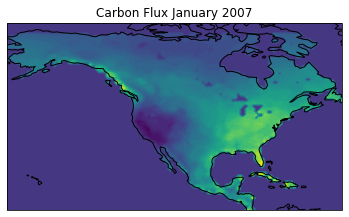

In [11]:
# grid mapping function
def data2grid(lats,lons,data):
    # create grid of lat lon (expand lat by 5 degrees)
    xi = np.arange(lons.min(), lons.max()+1,1)
    yi = np.arange(lats.min(), lats.max()+5,1)
    xi, yi = np.meshgrid(xi, yi)
    zi = np.zeros(yi.shape) # place holder for flux variable

    # loop over values, find index of lat & lon, enter flux variable
    for i in range(len(data)):
        min_temp_lat=abs(lats[i]-yi[:,0])
        min_temp_lon=abs(lons[i]-xi[0,:])
        lat_ind = (min_temp_lat == min(min_temp_lat))
        lon_ind = (min_temp_lon == min(min_temp_lon))
        zi[lat_ind,lon_ind]=data[i]
    return xi, yi, zi

# plotting example

# plot flux data
flux = nc_inv.variables['monthly_flux'][0, :] # note shape of flux is [space dimension x time dimension]

# save lat lon from **MODIS** variable ****<<<<<IMPORTANT>>>>>******
lats = nc_modis.variables['lat'][:]
lons = nc_modis.variables['lon'][:]

xi, yi, zi_flux = data2grid(lats,lons,flux) # regrid for plotting

# projection axis    
ax = plt.axes(projection=ccrs.PlateCarree())

# plot contour of variable using gridded  lat, lon, and variable
plt.contourf(xi, yi, zi_flux, 60,
             transform=ccrs.PlateCarree())
# add coasts
ax.coastlines()

# title
plt.title("Carbon Flux January 2007")

plt.show()

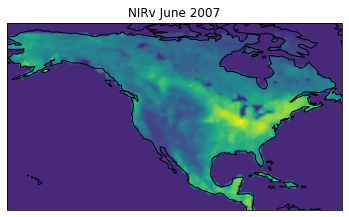

In [17]:
#plot predictor NIRv
flux = nc_modis.variables['NIRv'][:,5] # note shape of predictors is [time dimension x space dimension]

xi, yi, flux = data2grid(lats,lons,flux) # regrid for plotting

# projection axis    
ax = plt.axes(projection=ccrs.PlateCarree())

# plot contour of variable using gridded  lat, lon, and variable
plt.contourf(xi, yi, flux, 60,
             transform=ccrs.PlateCarree())
# add coasts
ax.coastlines()

# title
plt.title("NIRv June 2007")

plt.show()

In [9]:
# Variables are: 'x', 'time','monthly_flux','se_monthly_flux'
# Dimensions are: 2613 (spatial) and 108 (time) = 12months * 9 years
flux_x = nc_inv.variables['x'][:]  # 'x' index of spatial dimensions
flux_var = np.transpose(nc_inv.variables['monthly_flux'][:])  # 'monthly_flux' carbon fluxes transpose for organization
flux_var=flux_var.reshape((2613*108, 1), order='F') # reshape into one vector by stacking each month
flux_var.shape


(282204, 1)

In [12]:
# Create the pandas DataFrame with flux and predictors
df = pd.DataFrame(flux_var, columns = ['flux']) 
  